In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
isi_amp_dir = './isi_amp_data'
files = os.listdir(isi_amp_dir)


In [3]:
data_indexes = np.empty((528, 320, 456))
data = {}

In [4]:
df = pd.read_csv('./isi_amp_data/' + files[0])

In [5]:
df

,Unnamed: 0,channel,ml,ap,dv,atlas_id,clu_count,amp_min,amp_max,0.001,0.0027825594022071257,0.007742636826811269,0.021544346900318832,0.05994842503189409,0.1668100537200059,0.46415888336127775,1.2915496650148828,3.593813663804626,10.0
0,1,6.0,5121.0,8650.0,3659.0,128.0,1.0,0.000142,0.000142,0.000000,0.000000,0.000000,0.020408,0.081633,0.153061,0.204082,0.239796,0.209184,0.091837
1,2,7.0,5121.0,8650.0,3659.0,128.0,1.0,0.000146,0.000146,0.001153,0.001153,0.014418,0.083622,0.211649,0.325260,0.289504,0.071511,0.001730,0.000000
2,5,22.0,5100.0,8650.0,3496.0,128.0,3.0,0.000127,0.000232,0.000000,0.000000,0.019892,0.050633,0.150090,0.182640,0.247740,0.233273,0.108499,0.007233
3,6,23.0,5100.0,8650.0,3496.0,128.0,1.0,0.000118,0.000118,0.000970,0.001109,0.022450,0.205377,0.641353,0.112389,0.014412,0.001802,0.000139,0.000000
4,7,24.0,5094.0,8650.0,3476.0,128.0,2.0,0.000181,0.000182,0.014080,0.061463,0.202520,0.456796,0.211328,0.051884,0.001929,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,178,338.0,4423.0,8406.0,357.0,965.0,3.0,0.000063,0.000079,0.004587,0.011927,0.047706,0.131193,0.176147,0.208257,0.229358,0.160550,0.028440,0.001835
161,179,339.0,4423.0,8406.0,357.0,965.0,1.0,0.000052,0.000052,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
162,180,342.0,4411.0,8399.0,319.0,671.0,5.0,0.000044,0.000081,0.010849,0.031908,0.126994,0.259732,0.185067,0.125718,0.146777,0.084876,0.027441,0.000638
163,181,343.0,4411.0,8399.0,319.0,671.0,2.0,0.000080,0.000086,0.000662,0.001324,0.011251,0.037062,0.183322,0.386499,0.287227,0.085374,0.007280,0.000000


In [6]:
volume_indexes_load = np.fromfile('./compression/volume_indexes.bytes',dtype='uint8')
volume_indexes = volume_indexes_load.reshape((528,320,456))

In [13]:
print(np.sum(volume_indexes[:,:,0:229]>0))

16270435


In [7]:
# we're going to fold all data over onto the same side
data_indexes = np.full((528, 320, 229),np.nan)
data = {}
pos_id = 1
data_indexes[volume_indexes[:,:,0:229]==1] = 0

for file in files:
    df = pd.read_csv('./isi_amp_data/' + file)
    df.reset_index()
    for i,row in df.iterrows():
        area = row['atlas_id']
        ml = int(row['ml']/25)
        ap = int(row['ap']/25)
        dv = int(row['dv']/25)
        if ml > 228:
            ml = 456-ml
        clu_count = row['clu_count']
        amp_min = row['amp_min']
        amp_max = row['amp_max']
        isi_data = row[9:].values
        
        if data_indexes[ap,dv,ml]==0 or np.isnan(data_indexes[ap, dv, ml]):
            data[pos_id] = np.concatenate(([area, clu_count, amp_min, amp_max], isi_data))
            data_indexes[ap,dv,ml] = pos_id
            pos_id+=1
        else:
            # the data point already exists
            prev = data[data_indexes[ap,dv,ml]]
            prev[1] += clu_count
            prev[2] = (prev[2]+amp_min)/2
            prev[3] = (prev[3]+amp_max)/2
            # average all the data
            prev[4:] = (prev[4:]+isi_data)/2
            data[data_indexes[ap,dv,ml]] = prev
        
print(pos_id)
print(np.sum(data_indexes==0))
print(np.sum(data_indexes>0))

48800
16222035
48799


In [10]:
print(np.sum(np.isnan(data_indexes)))

22421006


In [191]:
data_indexes.shape

(528, 320, 229)

In [15]:
orig = data_indexes.copy() # for later comparison

In [16]:
# better algorithm
nonzero_indices = np.argwhere(data_indexes>0)
values = data_indexes[data_indexes>0]

zero_indices = np.argwhere(data_indexes==0)
dist = np.full((528,320,229),np.nan)

In [17]:
distances = np.full(nonzero_indices.shape,np.nan)
for i in np.arange(len(zero_indices)):
    pos = zero_indices[i]
    distances = np.sum(np.power(nonzero_indices - pos,2),axis=1)
    data_indexes[pos[0],pos[1],pos[2]] = values[np.argmin(distances)]
    dist[pos[0],pos[1],pos[2]] = np.sqrt(np.min(distances))

KeyboardInterrupt: 

In [31]:
distvals = dist[np.invert(np.isnan(dist))]

(array([9.917231e+06, 3.467816e+06, 7.402080e+05, 2.164160e+05,
        1.435000e+05, 1.185840e+05, 9.686700e+04, 6.486500e+04,
        3.275100e+04, 6.831000e+03]),
 array([ 1.        , 10.88849338, 20.77698676, 30.66548014, 40.55397352,
        50.4424669 , 60.33096028, 70.21945366, 80.10794704, 89.99644042,
        99.8849338 ]),
 <BarContainer object of 10 artists>)

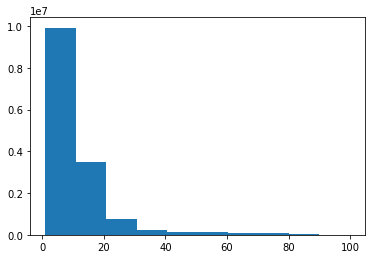

In [34]:
plt.hist(distvals)

In [36]:
print(np.sum(distvals>4)/len(distvals))
print(np.sum(distvals>8)/len(distvals))
print(np.sum(distvals>12)/len(distvals))

0.8364096783338193
0.5161517315454592
0.2838187380281713


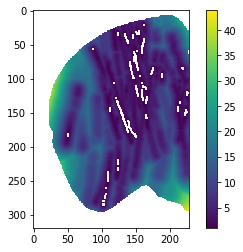

In [37]:
im = plt.imshow(dist[300,:,:])
cbar = plt.colorbar(im)

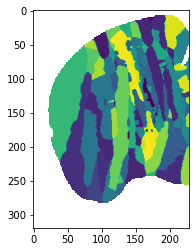

In [5]:
plt.imshow(data_indexes[325,:,:])

In [199]:
np.save('ea_hemisphere_mapping.npy',data_indexes)

In [201]:
df.columns

Index(['Unnamed: 0', 'channel', 'ml', 'ap', 'dv', 'atlas_id', 'clu_count',
       'amp_min', 'amp_max', '0.001', '0.0027825594022071257',
       '0.007742636826811269', '0.021544346900318832', '0.05994842503189409',
       '0.1668100537200059', '0.46415888336127775', '1.2915496650148828',
       '3.593813663804626', '10.0'],
      dtype='object')

In [211]:
a = ['area','clu_count','amp_min','amp_max']

In [213]:
a.extend(df.columns[9:])
print(a)

['area', 'clu_count', 'amp_min', 'amp_max', '0.001', '0.0027825594022071257', '0.007742636826811269', '0.021544346900318832', '0.05994842503189409', '0.1668100537200059', '0.46415888336127775', '1.2915496650148828', '3.593813663804626', '10.0']


In [227]:
columns = ['index','area','clu_count','amp_min','amp_max','i0','i1','i2','i3','i4','i5','i6','i7','i8','i9']

data_array = np.zeros((len(data),len(columns)))
for i, idx in enumerate(data.keys()):
    data_array[i,0] = idx
    data_array[i,1:] = data[idx]

final_df = pd.DataFrame(data=data_array,columns=columns)

In [228]:
final_df.to_csv('ea_hemisphere_data.csv')

In [5]:
# Try alternate file formats
data_indexes = np.load('ea_hemisphere_mapping.npy')
df = pd.read_csv('ea_hemisphere_data.csv')

In [6]:
data_indexes.shape

(528, 320, 229)

In [18]:
np.argwhere(df['index'].values==13986)[0][0]

13985

In [23]:
data_indexes[100,180,150]

nan

In [22]:
df.iloc[np.argwhere(df['index'].values==data_indexes[100,180,150])[0][0]].values.tolist()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [10]:
df

,row,index,area,clu_count,amp_min,amp_max,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9
0,0,1,128,2,0.000144,0.000144,0.000577,0.000577,0.007209,0.052015,0.146641,0.239160,0.246793,0.155653,0.105457,0.045918
1,1,2,128,4,0.000123,0.000175,0.000485,0.000554,0.021171,0.128005,0.395721,0.147515,0.131076,0.117537,0.054319,0.003617
2,2,3,128,2,0.000181,0.000182,0.014080,0.061463,0.202520,0.456796,0.211328,0.051884,0.001929,0.000000,0.000000,0.000000
3,3,4,128,2,0.000131,0.000184,0.000000,0.010152,0.030457,0.086294,0.182741,0.213198,0.147208,0.131980,0.126904,0.071066
4,4,5,128,4,0.000159,0.000216,0.000083,0.013558,0.064856,0.224330,0.235656,0.271081,0.106895,0.041873,0.020833,0.020833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48794,48794,48795,1033,3,0.000138,0.000154,0.002793,0.010109,0.074016,0.171790,0.204184,0.182668,0.165182,0.106349,0.040518,0.042390
48795,48795,48796,1033,4,0.000170,0.000170,0.001376,0.066407,0.205558,0.199437,0.168769,0.157355,0.091055,0.051048,0.030702,0.028293
48796,48796,48797,1033,1,0.000194,0.000194,0.014170,0.103239,0.143725,0.165992,0.184211,0.176113,0.117409,0.048583,0.016194,0.030364
48797,48797,48798,1033,1,0.000094,0.000094,0.002239,0.009963,0.195231,0.329788,0.290160,0.115079,0.039628,0.011642,0.004590,0.001679
